# SIEM and SBM Tests

In [1]:
import graspy
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import dask
from dask.distributed import Client, progress
import dask.dataframe as ddf
#uncomment when placed into model folder not doc
#from .base import BaseGraphEstimator, _calculate_p

from scipy.stats import bernoulli, mannwhitneyu, fisher_exact, chi2_contingency
from FisherExact import fisher_exact as fisher_exact_multi
from scipy import stats
from scipy.special import expit
import pandas as pd 
import mizani as miz

from graspy.simulations import sbm, er_np, er_nm
from graspy.plot import heatmap

import statsmodels.api as sm
import statsmodels.formula.api as smf

from graspy.models.base import BaseGraphEstimator 
from graspy.utils.utils import (
    augment_diagonal,
    cartprod,
    import_graph,
    is_unweighted,
    remove_loops,
    symmetrize,
)
import sys
import plotnine as p9
from dfply import *


/Users/bijanvarjavand/Documents/spring20/ndd/venv-graspy/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
def siem(n, p, edge_comm, directed=False, loops=False, wt=None, wtargs=None,
        return_labels=False):
    """
    Samples a graph from the structured independent edge model (SIEM) 
    SIEM produces a graph with specified communities, in which each community can
    have different sizes and edge probabilities. 
    Read more in the :ref:`tutorials <simulations_tutorials>`
    Parameters
    ----------
    n: int
        Number of vertices
    p: list of int of length K (k_communities)
        Probability of an edge existing within the corresponding communities, where p[i] indicates 
        the probability of an edge existing in the edge_comm[i]
    edge_comm: 2d list of K tuples (k_communities)
        tuple is the indices for the edge within the kth community.
    directed: boolean, optional (default=False)
        If False, output adjacency matrix will be symmetric. Otherwise, output adjacency
        matrix will be asymmetric.
    loops: boolean, optional (default=False)
        If False, no edges will be sampled in the diagonal. Otherwise, edges
        are sampled in the diagonal.
    wt: object or list of K objects (k_communities)
        if Wt is an object, a weight function to use globally over
        the siem for assigning weights. If Wt is a list, a weight function for each of
        the edge communities to use for connection strengths Wt[i] corresponds to the weight function
        for edge community i. Default of None results in a binary graph
    wtargs: dictionary or array-like, shape (k_communities)
        if Wt is an object, Wtargs corresponds to the trailing arguments
        to pass to the weight function. If Wt is an array-like, Wtargs[i, j] 
        corresponds to trailing arguments to pass to Wt[i, j].
    return_labels: boolean, optional (default = False)
        IF True, returns the edge-communities as well
    References
    ----------
    Returns
    -------
    A: ndarray, shape (sum(n), sum(n))
        Sampled adjacency matrix
    T: returns the edge-communities if return_labels == True
    """
    # Check n
    if not isinstance(n, (int)):
        msg = "n must be a int, not {}.".format(type(n))
        raise TypeError(msg)
    # Check edge_comm 
    if not isinstance(edge_comm, (list)):
        msg = "edge_comm must be a 2d list of length k."
        raise TypeError(msg)
    else: 
        for i in range(len(edge_comm)):
            for x in edge_comm[i]:
                if not (len(x)==2 and isinstance (x,tuple)):
                    msg = "The edge_comm list must contain tuples of 2 elements."
                    raise TypeError(msg)
        #edge_comm = np.array(edge_comm)
        #generate temporary adjacency matrix to check upper triangular?
        if (directed == True) and (loops == True):
            if not(sum(len(x) for x in edge_comm) <= n**2) : 
                msg = "Edge Communities and Number of Vertices Do Not Agree, {} must be <= n**2 !".format(sum(len(x) for x in edge_comm))
                raise ValueError(msg)
        elif (directed == True) and (loops == False): 
            if not(sum(len(x) for x in edge_comm) <= n*(n-1)/2): 
                msg = "Edge Communities and Number of Vertices Do Not Agree, {} must be <= n(n-1)/2!".format(sum(len(x) for x in edge_comm))
                raise ValueError(msg)            
        elif (directed == False) and (loops == True):
            #check symmetry ?
            if not(sum(len(x) for x in edge_comm) <= n*(n-1)) : 
                msg = "Edge Communities and Number of Vertices Do Not Agree, {} must be <= n(n-1)!".format(sum(len(x) for x in edge_comm))
                raise ValueError(msg)            
        elif (directed == False) and (loops == False): 
            #check symmetry ?
            if not(sum(len(x) for x in edge_comm) <= n**2/2) : 
                msg = "Edge Communities and Number of Vertices Do Not Agree, {} must be <= n**2/2!".format(sum(len(x) for x in edge_comm))
                raise ValueError(msg)            
    # Check p
    if not isinstance(p, (list, np.ndarray)):
        msg = "p must be a list or np.array, not {}.".format(type(p))
        raise TypeError(msg)
    else:
        p = np.array(p)
        if not np.issubdtype(p.dtype, np.number):
            msg = "There are non-numeric elements in p"
            raise ValueError(msg)
        elif np.any(p < 0) or np.any(p > 1):
            msg = "Values in p must be in between 0 and 1."
            raise ValueError(msg)
        elif len(p) != len(edge_comm):
            msg = "# of Probabilities and # of Communities Don't Match Up"
            raise ValueError(msg)
    # Check wt and wtargs
    if (wt is not None) and (wtargs is not None): 
        if callable(wt):
            #extend the function to size of k 
            wt = np.full(len(edge_comm), wt, dtype=object)
            wtargs = np.full(len(edge_comm), wtargs, dtype=object)
        elif type(wt) == list:
            if all(callable(x) for x in wt): 
                # if not object, check dimensions
                if len(wt) != (len(edge_comm)):
                    msg = "wt must have size k, not {}".format(len(wt))
                    raise ValueError(msg)
                if len(wtargs) != (len(edge_comm)):
                    msg = "wtargs must have size k , not {}".format(len(wtargs))
                    raise ValueError(msg)
                # check if each element is a function
                for element in wt.ravel():
                    if not callable(element):
                        msg = "{} is not a callable function.".format(element)
                        raise TypeError(msg)   
            else: 
                msg = "list must contain all callable objects"
                raise ValueError(msg)
        else:
            msg = "wt must be a callable object or list of callable objects"
            raise ValueError(msg)

    K = len(edge_comm) # the number of communities
    # End Checks, begin simulation
    A = np.zeros((n,n))

    # list of lists of 2-d tuples version
    for i in range(0, K):
        #sample bernoulli at once
        rvs = bernoulli.rvs(p[i],size = len(edge_comm[i]))
        #iterate over each index
        for x in range(len(edge_comm[i])):
            #set each equal to bernoulli 
            A[edge_comm[i][x]] = rvs[x]
            #adjust adjacency matrix with any weight args. 
            if (wt is not None) and (wtargs is not None): 
                    A[edge_comm[i][x]] = A[edge_comm[i][x]]*wt[i](**wtargs[i])
    
    if not directed:
        A = A + A.T - np.diag(A)
    
    if return_labels:
        return (A, edge_comm)
    else:
        return A

In [3]:
def gen_pmat(num_blocks, effect_size=0):
    if num_blocks == 2:
        # tend to [[a, b], [b, a]]
        pmat = np.array([[.5 + effect_size/2, .5 - effect_size/2], [.5 - effect_size/2, .5 + effect_size/2]])
    elif num_blocks == 3:
        # tend to [[a, b], [b, d]]
        pmat = np.array([[.5 + effect_size/2, .5], [.5, .5 - effect_size/2]])
    elif num_blocks == 4:
        # tend to [[a, b], [c, d]]
        pmat = np.array([[.5 + effect_size/2, .5 + effect_size/4], [.5 - effect_size/4, .5 - effect_size/2]])
    return pmat

def quad_sbm(n, pmat, weighted=False, return_labels=False):
    comm = [n//2, n//2]
    if weighted:
        raise NotImplementedError()
    else:
        mat = graspy.simulations.sbm(comm, pmat, directed=True, loops=True, return_labels=return_labels)
    return mat
        
def sample_quad_sbm(n, effect_size=0, num_blocks=4, weighted=False, return_labels=False):
    pmat = gen_pmat(num_blocks, effect_size)
    mat = quad_sbm(n, pmat, weighted=weighted, return_labels=return_labels)
    return mat

def sbm_2(n, effect_size=0, weighted=False, return_labels=True):
    return sample_quad_sbm(n, effect_size=effect_size, num_blocks=2, weighted=weighted, return_labels=return_labels)

def sbm_3(n, effect_size=0, weighted=False, return_labels=True):
    return sample_quad_sbm(n, effect_size=effect_size, num_blocks=3, weighted=weighted, return_labels=return_labels)

def sbm_4(n, effect_size=0, weighted=False, return_labels=True):
    return sample_quad_sbm(n, effect_size=effect_size, num_blocks=4, weighted=weighted, return_labels=return_labels)

In [4]:
def expand_labels(C, mode='abba'):
    if mode == 'abba':
        return np.outer(1-C, C) + np.outer(C, 1-C) + 1
    elif mode == 'abbd':
        return np.outer(1-C, C) + np.outer(C, 1-C) + 2*np.outer(C, C) + 1
    elif mode == 'abcd':
        return np.outer(C+1, C+2) - 1 - np.outer(C, C)
    return None

def fishers_exact_multi(G, C, workspace=300):
    """
    G is a binary graph, C is community assignments.
    """
    T1 = np.zeros((2,2))
    T2 = np.zeros((2,3))
    # T3 = np.zeros((2,3))
    T4 = np.zeros((2,4))
    
    # [[a, b], [b, a]]
    comm = expand_labels(C, mode='abba')
    for k in range(0, 2):
        T1[0,k] = (G[comm == (k+1)]).sum()
        T1[1,k] = len(G[comm == (k+1)]) - T1[0,k]
    pval_ab = fisher_exact_multi(T1, workspace=workspace)
    
    # [[a, b], [b, d]]
    comm = expand_labels(C, mode='abbd')
    for k in range(0, 3):
        T2[0,k] = (G[comm == (k+1)]).sum()
        T2[1,k] = len(G[comm == (k+1)]) - T2[0,k]
    pval_abd = fisher_exact_multi(T2, workspace=workspace)
    
    # [[a, b], [c, d]]
    comm = expand_labels(C, mode='abcd')
    for k in range(0, 4):
        T4[0,k] = (G[comm == (k+1)]).sum()
        T4[1,k] = len(G[comm == (k+1)]) - T4[0,k]
    pval_abcd = fisher_exact_multi(T4, workspace=workspace)
    
    pvals = [(pval_ab, 0), (pval_abd, 1), (pval_abcd, 2)]
    pvals.sort()
    count = 3
    for pval in pvals:
        if pval[0] < 0.05/count:
            return pval
        count -= 1
    return (pvals[0][0], -1)

def fishers_exact_multi_nested(G, C, workspace=300):
    """
    G is a binary graph, C is community assignments.
    """
    T1 = np.zeros((2,2))
    T2 = np.zeros((2,3))
    # T3 = np.zeros((2,3))
    T4 = np.zeros((2,4))
    
    # [[a, b], [b, a]]
    comm = expand_labels(C, mode='abba')
    for k in range(0, 2):
        T1[0,k] = (G[comm == (k+1)]).sum()
        T1[1,k] = len(G[comm == (k+1)]) - T1[0,k]
    pval_ab = fisher_exact_multi(T1, workspace=workspace)
    if pval_ab <= 0.05:
        return (pval_ab, 0)
    
    # [[a, b], [b, d]]
    comm = expand_labels(C, mode='abbd')
    for k in range(0, 3):
        T2[0,k] = (G[comm == (k+1)]).sum()
        T2[1,k] = len(G[comm == (k+1)]) - T2[0,k]
    pval_abd = fisher_exact_multi(T2, workspace=workspace)
    if pval_abd <= 0.05:
        return (pval_abd, 1)
    
    # [[a, b], [c, d]]
    comm = expand_labels(C, mode='abcd')
    for k in range(0, 4):
        T4[0,k] = (G[comm == (k+1)]).sum()
        T4[1,k] = len(G[comm == (k+1)]) - T4[0,k]
    pval_abcd = fisher_exact_multi(T4, workspace=workspace)
    if pval_abcd <= 0.05:
        return (pval_abcd, 2)
    
    return (np.min([pval_ab, pval_abd, pval_abcd]), -1)

def chi2_multi(G, C):
    T1 = np.zeros((2,2))
    T2 = np.zeros((2,3))
    # T3 = np.zeros((2,3))
    T4 = np.zeros((2,4))
    
    # [[a, b], [b, a]]
    comm = expand_labels(C, mode='abba')
    for k in range(0, 2):
        T1[0,k] = (G[comm == (k+1)]).sum()
        T1[1,k] = len(G[comm == (k+1)]) - T1[0,k]
    pval_ab = chi2_contingency(T1)[1]
    
    # [[a, b], [b, d]]
    comm = expand_labels(C, mode='abbd')
    for k in range(0, 3):
        T2[0,k] = (G[comm == (k+1)]).sum()
        T2[1,k] = len(G[comm == (k+1)]) - T2[0,k]
    pval_abd = chi2_contingency(T2)[1]
    
    # [[a, b], [c, d]]
    comm = expand_labels(C, mode='abcd')
    for k in range(0, 4):
        T4[0,k] = (G[comm == (k+1)]).sum()
        T4[1,k] = len(G[comm == (k+1)]) - T4[0,k]
    pval_abcd = chi2_contingency(T4)[1]
    
    pvals = [(pval_ab, 0), (pval_abd, 1), (pval_abcd, 2)]
    pvals.sort()
    count = 3
    for pval in pvals:
        if pval[0] < 0.05/count:
            return pval
        count -= 1
    return (pvals[0][0], -1)

def lrt_multi(G, C):
    G_vec = G.flatten()
    # [[a, b], [b, a]]
    comm = expand_labels(C, mode='abba').flatten()
    model_null = smf.glm(formula='Edges~1',
                    data=pd.DataFrame({'Edges': G_vec, 'Community': comm}),
                    family=sm.families.Binomial()).fit()
    model = smf.glm(formula='Edges~Community',
                    data=pd.DataFrame({'Edges': G_vec, 'Community': comm}),
                    family=sm.families.Binomial()).fit()
    dof = model_null.df_resid - model.df_resid
    lrs = 2*(model.llf - model_null.llf)
    lr_pval_abba = stats.chi2.sf(lrs, df=dof)
    
    # [[a, b], [b, d]]
    comm = expand_labels(C, mode='abbd').flatten()
    model = smf.glm(formula='Edges~Community',
                    data=pd.DataFrame({'Edges': G_vec, 'Community': comm}),
                    family=sm.families.Binomial()).fit()
    dof = model_null.df_resid - model.df_resid
    lrs = 2*(model.llf - model_null.llf)
    lr_pval_abbd = stats.chi2.sf(lrs, df=dof)
    
    # [[a, b], [c, d]]
    comm = expand_labels(C, mode='abcd').flatten()
    model = smf.glm(formula='Edges~Community',
                    data=pd.DataFrame({'Edges': G_vec, 'Community': comm}),
                    family=sm.families.Binomial()).fit()
    dof = model_null.df_resid - model.df_resid
    lrs = 2*(model.llf - model_null.llf)
    lr_pval_abcd = stats.chi2.sf(lrs, df=dof)
    
    pvals = [(lr_pval_abba, 0), (lr_pval_abbd, 1), (lr_pval_abcd, 2)]
    pvals.sort()
    count = 3
    for pval in pvals:
        if pval[0] < 0.05/count:
            return pval
        count -= 1
    return (pvals[0][0], -1)
#     pval = np.min(pvals)
#     idx = np.argmin(pvals)
    
#     if pval > 0.05:
#         idx = -1
#     return (pval, idx)

def gather_matrix(mtx, weighted="", gr_type=""):
    """
    Converts a matrix to a pandas dataframe
    """
    pd_mtx = pd.DataFrame(mtx)
    pd_mtx.columns = np.arange(1, mtx.shape[0] + 1, 1)
    pd_mtx >>= gather('Column', 'Weight', add_id=True)
    pd_mtx=pd_mtx.rename(columns={"_ID": "Row"})
    pd_mtx["Weighting"]=weighted
    pd_mtx["Method"] = gr_type
    pd_mtx["Row"] = pd_mtx["Row"] + 1
    return(pd_mtx)

In [5]:
vals = [(0.05, 0), (0.2, 1), (0.1, 2)]
vals.sort()
print(vals)

[(0.05, 0), (0.1, 2), (0.2, 1)]


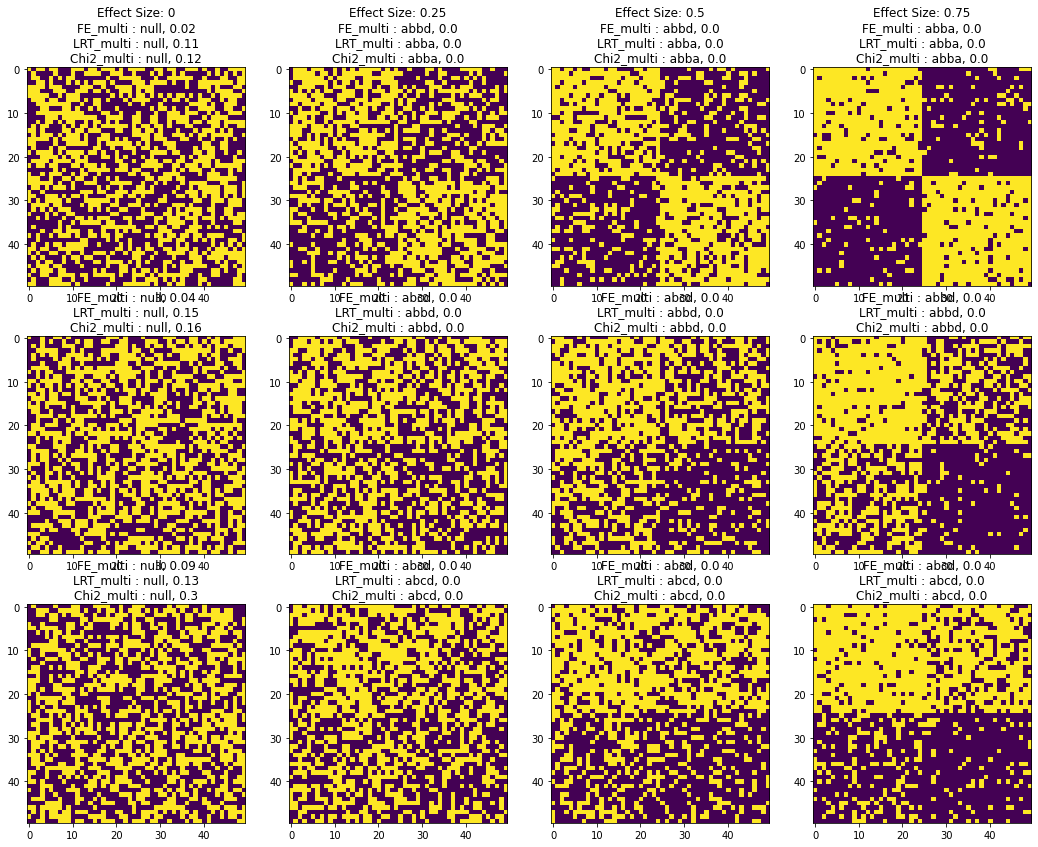

In [6]:
fig, ax = plt.subplots(3, 4, figsize=(18,14))
for j, func in enumerate([sbm_2, sbm_3, sbm_4]):
    i = 0
    for esize in [0, 0.25, 0.5, 0.75]:
        mat = func(50, esize, return_labels=True)
        pval_fe = fishers_exact_multi(mat[0], mat[1], workspace=5000)
        pval_lrt = lrt_multi(mat[0], mat[1])
        pval_chi2 = chi2_multi(mat[0], mat[1])
        ax[j][i].imshow(mat[0])
        header = 'Effect Size: ' + str(esize)
        mapper = {-1 : 'null', 0: 'abba', 1: 'abbd', 2: 'abcd'}
        title = 'FE_multi : ' + mapper[pval_fe[1]] + ', ' + str(round(pval_fe[0],2))\
            + '\n' + 'LRT_multi : ' + mapper[pval_lrt[1]] + ', '  + str(round(pval_lrt[0],2))\
            + '\n' + 'Chi2_multi : ' + mapper[pval_chi2[1]] + ', '  + str(round(pval_chi2[0],2))
        if j == 0:
            title = header  + '\n' + title
        ax[j][i].set_title(title)
        i += 1

In [7]:
# the color for each test statistic
test_stat_cols = {'FET': 'red',
                  'LRT': 'teal',
                  'Chi2': 'blue'}

# an array tracking the test statistics themselves
test_stats = {'FET': fishers_exact_multi,
              'LRT': lrt_multi,
              'Chi2': chi2_multi}

# an array for when to use different test statistics
test_stat_use = {'FET': ['Unweighted'],
                 'LRT': ['Unweighted'],
                 'Chi2': ['Unweighted']}

simulations = {
    'Unweighted': {'SBM_abba': {'fn': sbm_2, 'eff_sz': np.linspace(0, .15, 10),'kwarg': {"weighted": False}},
                   'SBM_abbd': {'fn': sbm_3, 'eff_sz': np.linspace(0, .15, 10),'kwarg': {"weighted": False}},
                   'SBM_abcd': {'fn': sbm_4, 'eff_sz': np.linspace(0, .15, 10),'kwarg': {"weighted": False}}
                  }
}

nrep = 100
ncores = 6
nvertices = np.round(np.linspace(20, 100, 10))

In [8]:
client = Client(threads_per_worker=1, n_workers=ncores)
client

<Client: 'tcp://127.0.0.1:62655' processes=6 threads=6, memory=17.18 GB>

# Simulations Driver

In [9]:
def run_exp(row):
    # generate simulation using the dictionary defined above
    sim_dict = simulations[row["Weighting"]][row["Simulation"]]
    if sim_dict["kwarg"] is not None:
        (A, C) = sim_dict["fn"](row["n"], row["Effect_Size"], **sim_dict["kwarg"])
    else:
        (A, C) = sim_dict["fn"](row["n"], row["Effect_Size"])
        
    # run sim on all test statistics
    p_vals = []
    models = []
    stat_names = []
    for test_name, test in test_stats.items():
        # check if statistic is appropriate for the setting
        if row["Weighting"] in test_stat_use[test_name]:
#             pval, model = test(A, C)
#             p_vals.append(pval)
#             models.append(model)
#             stat_names.append(test_name)
            try:
                pval, model = test(A, C)
                p_vals.append(pval)
                models.append(model)
                stat_names.append(test_name)
            except:
                try:
                    pval, model = test(A, C, workspace=10000)
                    p_vals.append(pval)
                    models.append(model)
                    stat_names.append(test_name)
                except:
                    ex_str = "Failed Test: {}, Simulation: {}, n: {}, Effect Size: {}"
                    print(ex_str.format(test_name, row["Simulation"], row["n"], row["Effect_Size"]))
                    p_vals.append(float("NaN"))
                    models.append(-10)
        else:
            p_vals.append(float("NaN"))
            models.append(-10)
    return tuple([row["Simulation"], row["Weighting"], row["n"],
                 row["Effect_Size"], row["i"], *p_vals, *models])

In [10]:
exps = []
for weighting, sims in simulations.items():
    for sim_name, sim in sims.items():
        for es in sim["eff_sz"]:
            for n in nvertices:
                for i in range(nrep):
                    exps.append([sim_name, weighting, n, es, i])
sim_exps = pd.DataFrame(exps, columns=["Simulation", "Weighting", "n", "Effect_Size", "i"])
sim_exps["n"] = sim_exps["n"].astype(int)
print(sim_exps.head())
print(sim_exps.shape)

  Simulation   Weighting   n  Effect_Size  i
0   SBM_abba  Unweighted  20          0.0  0
1   SBM_abba  Unweighted  20          0.0  1
2   SBM_abba  Unweighted  20          0.0  2
3   SBM_abba  Unweighted  20          0.0  3
4   SBM_abba  Unweighted  20          0.0  4
(30000, 5)


In [11]:
sim_exps = ddf.from_pandas(sim_exps, npartitions=10)
sim_results = sim_exps.apply(lambda x: run_exp(x), axis=1, result_type='expand',
                             meta={0: str, 1: str, 2: int, 3: float, 4: int,
                                   5: float, 6: float, 7: float, 8: int, 9: int, 10: int})

In [12]:
sim_results

Dask DataFrame Structure:
                    0       1      2        3      4        5        6        7      8      9      10
npartitions=10                                                                                       
0               object  object  int64  float64  int64  float64  float64  float64  int64  int64  int64
3000               ...     ...    ...      ...    ...      ...      ...      ...    ...    ...    ...
...                ...     ...    ...      ...    ...      ...      ...      ...    ...    ...    ...
27000              ...     ...    ...      ...    ...      ...      ...      ...    ...    ...    ...
29999              ...     ...    ...      ...    ...      ...      ...      ...    ...    ...    ...
Dask Name: apply, 20 tasks

In [ ]:
sim_results = sim_results.compute(scheduler="multiprocessing")
sim_results = sim_results.rename(columns={0: "Simulation", 1: "Weighting", 2: "n", 3: "Effect_Size",
                                          4: "i", 5: "FET", 6: "LRT", 7: "Chi2", 8: "FET_pred", 9: "LRT_pred", 10: "Chi2_pred"})
sim_results.to_pickle('./data/singlegraph_results.pkl')

Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333
Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333
Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333
Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666
Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333
Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333
Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666
Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0
Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0
Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333
Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333
Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0
Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666
Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333
Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0
Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333
Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666
Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666
Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333
Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333
Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333
Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1
Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333
Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666
Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333
Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666
Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05
Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333
Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666
Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333
Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666
Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333
Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666
Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1
Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05
Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333
Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333
Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333
Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1
Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333
Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05
Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15
Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1
Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1
Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15
Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15
Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05
Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05
Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333
Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333
Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05
Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666
Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1
Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333
Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333
Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1
Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666
Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05
Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333
Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666
Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333
Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666
Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1
Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0
Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1
Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0
Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333
Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1
Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333
Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667
Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667
Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667
Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667
Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667
Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667
Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667
Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667
Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667
Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0
Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667
Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667
Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0
Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05
Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667
Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05
Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.0


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.05


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666
Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 91, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abbd, n: 100, Effect Size: 0.016666666666666666
Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667
Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667
Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333
Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667
Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667
Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333
Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333
Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667
Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667
Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333
Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.06666666666666667
Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.11666666666666667


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.03333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333
Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333
Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abba, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333
Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.13333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.08333333333333333


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15
Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1
Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1
Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15
Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15
Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 91, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.15


Failed Test: FET, Simulation: SBM_abcd, n: 100, Effect Size: 0.1


In [ ]:
#sim_results = pd.read_pickle('./data/singlegraph_results.pkl')
sim_results >>= gather('Test', 'p_val', ['FET', 'LRT', "Chi2"])
sim_results.head()

In [ ]:
# threshold and compute power
@make_symbolic
def purge_nan(series):
    return np.invert(np.isnan(series))

@make_symbolic
def std_err(series):
    return np.std(series)/len(series)
alpha = .05
power_results = sim_results >> mask(purge_nan(X.p_val)) >> group_by(
    "Simulation", "Weighting", "n", "Effect_Size", "Test"
    ) >> mutate(outcome=(X.p_val < alpha).astype(float)
    ) >> summarize(power=X.outcome.mean(), power_stderr=std_err(X.outcome)
    ) >> group_by(
        "Simulation", "Weighting", "n"
    ) >> mutate(  # normalize the effect size so they are all on the same scale
        Effect_Size=np.around((X.Effect_Size - np.min(X.Effect_Size))/(np.max(X.Effect_Size)-np.min(X.Effect_Size)),
                             decimals=3)
    )
power_results["n"] = power_results["n"].astype('category')
power_results["n"].cat.reorder_categories(nvertices.astype(int), inplace=True)
power_results["Effect_Size"] = power_results["Effect_Size"].astype('category')
power_results["Effect_Size"].cat.reorder_categories(
    np.sort(np.unique(power_results["Effect_Size"])), inplace=True)
power_results.head(10)

# Unweighted Plots

## Power Plots

In [ ]:
uw_results = power_results >> mask(X.Weighting == "Unweighted")



In [ ]:
power_plot = (p9.ggplot(data=uw_results, mapping=p9.aes(x="n", y="Effect_Size", fill="power"))
 + p9.geom_tile()
 + p9.facet_grid("Simulation ~ Test")
 + p9.xlab("Number of Vertices")
 + p9.ylab("Effect Size")
 + p9.scale_fill_gradient(high="green", low="red", name="Power")
 + p9.scale_x_discrete(breaks=[20, 100])
 + p9.scale_y_discrete(breaks=[0, 1])
 + p9.theme_bw()
 + p9.theme(figure_size=(9, 4.5))
 + p9.ggtitle("(I) Unweighted Power Plot")
)

## Simulation Plots

In [ ]:
gr_dat = pd.concat([gather_matrix(sbm_2(50, effect_size=.5, weighted=False)[0], gr_type=r"$SBM_{abba}$"),
           gather_matrix(sbm_3(50, effect_size=.8, weighted=False)[0], gr_type=r"$SBM_{abbd}$"),
           gather_matrix(sbm_4(50, effect_size=.8)[0], gr_type=r"$SBM_{abcd}$")])
gr_dat.head()

In [ ]:
sim_plot = (p9.ggplot(data=gr_dat, mapping=p9.aes(x="factor(Row)", y="factor(Column)", fill="factor(Weight)"))
 + p9.geom_tile()
 + p9.facet_grid("Method~")
 + p9.xlab("Vertex 1")
 + p9.ylab("Vertex 2")
 + p9.scale_x_discrete(breaks=[1, 50])
 + p9.scale_y_reverse(breaks=[1, 50])
 + p9.scale_fill_discrete(name="Edge")
 + p9.theme_bw()
 + p9.theme(figure_size=(1.5, 4.5))
 + p9.ggtitle("(I) Simulation Plot")
)

In [ ]:
sim_plot

In [ ]:
power_plot

In [ ]:
def make_better(x):
    if x=='SBM_abba':
        return r'$SBM_{abba}$'
    elif x=='SBM_abbd':
        return r'$SBM_{abbd}$'
    elif x=='SBM_abcd':
        return r'$SBM_{abcd}$'

In [ ]:
uw_results['Simulation'] = uw_results['Simulation'].apply(make_better)

In [ ]:
uw_results

## Power (fixed $n$) plots

In [ ]:
power_fixed_dat = uw_results >> mask(X.n == 56)
slice_plot = (p9.ggplot(data=power_fixed_dat, mapping=p9.aes(x="Effect_Size", y="power", 
                                                color="factor(Test)", group="factor(Test)"))
 + p9.geom_line()
 + p9.facet_grid("Simulation~")
 + p9.xlab("Relative Effect Size")
 + p9.ylab("Power")
 + p9.scale_x_discrete(breaks=[0, 0.5, 1])
 + p9.scale_y_continuous(limits=[0, 1], breaks=[0, 1])
 + p9.scale_color_discrete(name="Test")
 + p9.geom_hline(mapping=p9.aes(yintercept=alpha))
 + p9.theme_bw()
 + p9.theme(figure_size=(1.5, 4.5))
 + p9.ggtitle("(III) Power Plots, n=56")
)

In [ ]:
slice_plot

# Weighted Plots

## Power Plots

In [ ]:
wt_results = power_results >> mask(X.Weighting == "Weighted")

(p9.ggplot(data=wt_results, mapping=p9.aes(x="n", y="Effect_Size", fill="power"))
 + p9.geom_tile()
 + p9.facet_grid("Simulation ~ Test")
 + p9.xlab("Number of Vertices")
 + p9.ylab("Effect Size")
 + p9.scale_fill_gradient(high="green", low="red", name="Power")
 + p9.scale_x_discrete(breaks=[20, 100])
 + p9.scale_y_discrete(breaks=[0, 1])
 + p9.theme_bw()
 + p9.theme(figure_size=(4.5, 6))
 + p9.ggtitle("(II) Weighted Power Plot")
)

## Simulation Plots

In [ ]:
gr_dat = pd.concat([gather_matrix(modular_sbm(50, effect_size=.5, weighted=True)[0], gr_type="SBM"),
           gather_matrix(diag_siem(50, effect_size=.8, weighted=True)[0], gr_type="SIEM"),
           gather_matrix(skew_modular_sbm(50, effect_size=3)[0], gr_type="SSBM"),
           gather_matrix(outlier_sbm(50, effect_size=.8, outlier=.4, outlier_sc=1.5)[0], gr_type="oSBM")])
gr_dat >>= group_by("Method") >> mutate(Weight=(X.Weight - np.min(X.Weight))/(np.max(X.Weight) - np.min(X.Weight)))
gr_dat.head()

In [ ]:
(p9.ggplot(data=gr_dat, mapping=p9.aes(x="factor(Row)", y="factor(Column)", fill="Weight"))
 + p9.geom_tile()
 + p9.facet_grid("Method~")
 + p9.xlab("Vertex 1")
 + p9.ylab("Vertex 2")
 + p9.scale_x_discrete(breaks=[1, 50])
 + p9.scale_y_reverse(breaks=[1, 50])
 + p9.theme_bw()
 + p9.theme(figure_size=(1.5, 6))
 + p9.ggtitle("(I) Simulation Plot")
)

## Power (fixed $n$) plots

In [ ]:
power_fixed_dat = wt_results >> mask(X.n == 56)
(p9.ggplot(data=power_fixed_dat, mapping=p9.aes(x="Effect_Size", y="power", 
                                                color="factor(Test)", group="factor(Test)"))
 + p9.geom_line()
 + p9.facet_grid("Simulation~")
 + p9.xlab("Relative Effect Size")
 + p9.ylab("Power")
 + p9.scale_x_discrete(breaks=[0, 0.5, 1])
 + p9.scale_y_continuous(limits=[0, 1], breaks=[0, 1])
 + p9.scale_color_discrete(name="Test")
 + p9.geom_hline(mapping=p9.aes(yintercept=alpha))
 + p9.theme_bw()
 + p9.theme(figure_size=(1.5, 6))
 + p9.ggtitle("(III) Power Plots, n=56")
)